In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

import cmocean
from matplotlib import cm
import matplotlib.pyplot as plt

import datajoint as dj
import static_nda as nda
from stimulus import stimulus 
from pipeline import meso, treadmill
from pipeline.utils import clocktools

pupil = dj.create_virtual_module('pipeline_eye','pipeline_eye')
stats = dj.create_virtual_module('neurodata_static_stats', 'neurodata_static_stats')
dics = np.load('/mnt/scratch07/zhiwei/static_scan_release_keys_filtered.npy', allow_pickle=True)
scan_key = dics[-3]

Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


The raster visualization of traces can occur at several time scales:

### Macro
Good for representing longer periods of scan and components with time constants much longer than a single trial (ex behavior over seconds / < 1Hz).  Should downsample data in order to fit a longer duration in the panel.

### Micro
Good for representing the resolution of data relative to trial duration, as well as components with time constants shorter than a single trial (example impulse/adaption to trial onset).  

### Aggregate
Good for representing the data that goes into the model for training.  In some cases this may be the same as micro, but in many cases training / test data is downsampled, and may be averaged per trial (static presentations).  

The determining factors on these raster type figures is the expected width of the figure, the expected pixel resolution of the image (printed, online, etc), and the desired duration / resolution of the traces being presented.  For reference, [nature figures](https://www.nature.com/nature/for-authors/final-submission#:~:text=All%20photographic%20images%20must%20be,size%20they%20can%20be%20used) are 89mm/3.5 inches wide for single column and 183 mm / 7.2 inches wide for double column, and are requested at a resolution of 300-600 dpi (which is also the typical resolution settings on many printers for default work).  

Thus, the expected pixel count is ~1050-2100 for single column, and ~2150-4300 for double column.

For a 5:2 aspect ratio and a single column figure at 300dpi, this comes out to ~ 400 units for 1050 timepoints.

At a display frequency of 1Hz for Macro, this is 1050s (approx. 1167 trials). 
At a display frequency of approx. 8Hz for Micro, this is approx. 131s (approx. 145 trials).
At a trial wise display frequency, this is 1050 trials. 

# Utility functions for handling nans

In [2]:
# 1d interpolation to fill nan values in trace, retaining nan gaps > len = preserve_gap (defaults to len 0)
def fill_nans(x, preserve_gap=None):
    """
    :param x:  1D array  -- will
    :return: the array with nans interpolated
    The input argument is modified.
    """ 
    # check if input argument indicate that large gaps should be kept in "keep" variable
    if preserve_gap is not None:
        assert preserve_gap % 2 == 1, "can only efficiently preserve odd gaps"
        # convolves np.isnan(trace) with preserve_gap length, to enumerage gap length centered on that position
        # values outside edges assumed nonnan
        # identifies position in center of gaps of length >= preserve gap
        # convolves with preserve_gap length, to keep all positions within range of centers located within
        # gap of length >= preserve gap
        keep = np.convolve(
            np.convolve(1 * np.isnan(x), np.ones(preserve_gap), mode="same")
            == preserve_gap,
            np.ones(preserve_gap, dtype=bool),
            mode="same",
        )
    else:
        # otherwise, keep vector set to all zeros
        keep = np.zeros(len(x), dtype=bool)

    # identify nan positions
    nans = np.isnan(x)

    # if all nans, set all trace values to zero
    # otherwise linearly interpolate values at all nan positions from surrounding non-nan positions
    # assumes regular sample intervals?
    x[nans] = (
        0
        if nans.all()
        else np.interp(nans.nonzero()[0], (~nans).nonzero()[0], x[~nans])
    )
    
    # reset trace values at keep positions to nan
    x[keep] = np.nan
    
    # return modified trace
    return x


class NaNSpline(InterpolatedUnivariateSpline):
    def __init__(self, x, y, **kwargs):
        
        # find nans in x or y
        xnan = np.isnan(x)
        ynan = np.isnan(y)
        
        # weights = nan in x or y
        w = xnan | ynan  # get nans
        
        # convert to arrays
        x, y = map(np.array, [x, y])  # copy arrays
        
        # set y at ynans to zero
        y[ynan] = 0
        
        # set x at xnans to interpolate between known x values
        x[xnan] = np.interp(np.where(xnan)[0], np.where(~xnan)[0], x[~xnan])
        
        # call InterpolatedUnivariateSpline init
        # interpolate with passed kwargs, including k=spline_degree and ext = extrapolation mode beyond boundaries
        # only pass positions that are not nan in x or y (effectively set weight of nan positions to zero)
        super().__init__(x[~w], y[~w], **kwargs)  

        # create interpolator to linearly interpolate x/y nans at any x position (1 = nan)
        self.nans = interp1d(x, 1 * w, kind='linear')

    def __call__(self, x, **kwargs):
        # instantiate zero weight vectors
        ret = np.zeros_like(x)
        newnan = np.zeros_like(x)

        # mark current nan positions in x vector with ones
        old_nans = np.isnan(x)
        newnan[old_nans] = 1
        
        # interpolate remaining positions from x/y nan interpolator
        newnan[~old_nans] = self.nans(x[~old_nans])

        # find any position that is currently nan or nan adjacent from the linear interpolator
        idx = newnan > 0
        
        # set those positions to nan
        ret[idx] = np.nan
        
        # all other positions, interpolate from the spline, 
        # passing kwargs (including k = spline degree,ext = extrapolation mode)
        ret[~idx] = super().__call__(x[~idx], **kwargs)
        return ret

## Prepare Scan Traces

In [14]:
displayed_units = 400

# will fetch random units, in order to display representative traces
unit_keys = (meso.Activity.Trace & scan_key).fetch('KEY',order_by='RAND()',limit=displayed_units)


In [ ]:

# downsample from scan depth times (nframes * ndepths) to scan frame times 
ndepth = len(dj.U('z') & (meso.ScanInfo.Field & scan_key))
frame_times = (stimulus.Sync & scan_key).fetch1("frame_times").squeeze()[::ndepth]

# restrict to masks classified as soma
soma = meso.MaskClassification.Type() & dict(type="soma")

# fetch traces, delays, and keys
spikes = (dj.U("field", "channel") * meso.Activity.Trace * meso.ScanSet.UnitInfo * meso.ScanSet.Unit & soma & scan_key)

traces, ms_delay, trace_keys = spikes.fetch("trace", "ms_delay", dj.key, 
                                            order_by="animal_id, session, scan_idx, unit_id")

# stack traces, linearly interpolate across all nans (no nan gap preservation)
traces = np.vstack([fill_nans(tr.astype(np.float32)).squeeze() for tr in traces])

# correct delay from ms to s
delay = np.fromiter(ms_delay / 1000, dtype=np.float)

# create frame times vector for each trace, including estimated delay per trace
frame_times_mat = delay[:, None] + frame_times[None, :]

# clip to same trace length
traces, frame_times_mat = adjust_trace_len(traces, frame_times_mat)

# find beginning and end of scan frame times
ftmin,ftmax = frame_times_mat.min(),frame_times_mat.max()

# create complete trace keys for all traces
trace_keys = [dict(scan_key, **trace_key) for trace_key in trace_keys]


In [3]:
displayed_units = 200

# will fetch random units, in order to display representative traces
unit_keys = np.random.choice((meso.Activity.Trace & scan_key).fetch('KEY'),displayed_units,replace=False)

# will fetch in order of oracle scores, to display higher oracle units first
# unit_keys = (stats.Oracle.UnitScores & scan_key).fetch('KEY',order_by='pearson DESC',limit=displayed_units)

# downsamples and crops recorded aligned scan frame times to extract scan field1_times
depth_times = (stimulus.Sync & scan_key).fetch1('frame_times')
nscanframes,nfields,fps = (meso.ScanInfo & scan_key).fetch1('nframes','nfields','fps')
field1_times_stim = depth_times[:nfields*nscanframes:nfields]

# fetch traces and delays (relative to field1_times_stim, ms)
traces,delays = ((meso.ScanSet.UnitInfo & unit_keys) * meso.Activity.Trace).fetch('trace','ms_delay')

## Prepare Stimulus to Behavior clock conversion (at matched scan field1 frame times)

In [4]:
beh_times = (stimulus.BehaviorSync & scan_key).fetch1('frame_times')
field1_times_beh = beh_times[:nfields*nscanframes:nfields]
st2bt = interp1d(field1_times_stim,field1_times_beh,kind='linear') #stimulus time to behavior time

## Prepare Eye Traces

In [5]:
pupil_times = (pupil.Eye & scan_key).fetch1('eye_time')

pupil_rel = pupil.FittedPupil.Circle & scan_key & 'tracking_method=2'
pupil_rs,pupil_centers = pupil_rel.fetch('radius','center',order_by = 'frame_id ASC')
pupil_centers = np.array([p if p is not None else np.array([np.nan, np.nan]) for p in pupil_centers])
pupil_xs = pupil_centers[:, 0]
pupil_ys = pupil_centers[:, 1]



## Prepare Treadmill Traces

In [6]:
tread_vels, tread_times = (treadmill.Treadmill & scan_key).fetch1('treadmill_vel','treadmill_time')

## Find Most Successful Tracking Range

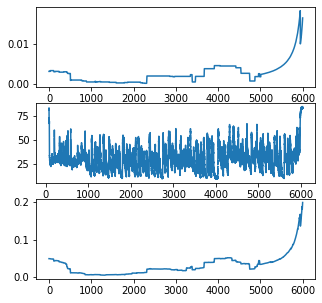

In [7]:
duration = 1050
resample_freq = 1

trial_ids,flip_times = (stimulus.Trial & scan_key & stimulus.Frame).fetch('trial_idx','flip_times')

nan_rates,mean_tread_amps = [],[]
for flip_time in flip_times:
    radii_in_window = pupil_rs[np.logical_and(pupil_times>=st2bt(flip_time[0][0]), 
                                              pupil_times<=st2bt(flip_time[0][0])+(duration/resample_freq))]
    nan_rate = np.sum(np.isnan(radii_in_window)) / len(radii_in_window)
    nan_rates.append(nan_rate)
    
    tread_in_window = tread_vels[np.logical_and(tread_times>=st2bt(flip_time[0][0]), 
                                                tread_times<=st2bt(flip_time[0][0])+(duration/resample_freq))]
    mean_tread_amps.append(np.nanmean(np.abs(tread_in_window)))
fig,axes = plt.subplots(3,1,figsize=(5,5))
axes[0].plot(trial_ids,nan_rates)
axes[1].plot(pupil_times,pupil_rs)
axes[2].plot(trial_ids,mean_tread_amps)


## Macro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in remainder


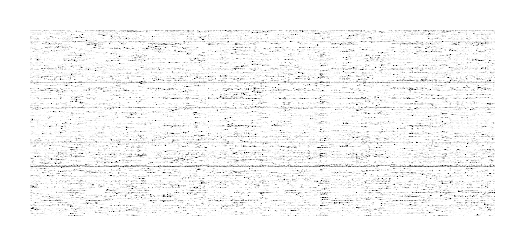

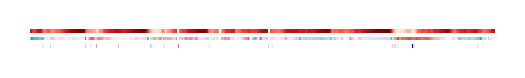

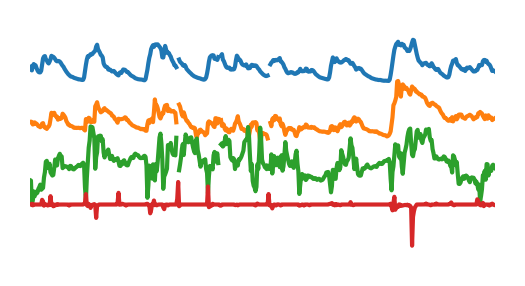

In [8]:
first_trial = 2000
onset = (stimulus.Trial & scan_key & f'trial_idx = {first_trial}').fetch1('flip_times')[0][0]
duration = 500 # in frames
resample_freq = 1

# choose resample times in stimulus clock at desired resample frequency
resample_times = np.linspace(onset,onset+duration/resample_freq,duration)

# hamming filter for downsample resample frequencies
sampling_freq = 1 / np.nanmedian(np.diff(field1_times_stim))
h = np.hamming(2 * int(sampling_freq / resample_freq) + 1)
filtered_traces = [np.convolve(t, h/sum(h), mode='same') for t in traces]
f2as = [interp1d(field1_times_stim+d/1000,t,kind='linear') 
        for d,t in zip(delays,filtered_traces)] # frame to activity
display_traces = [f2a(resample_times) for f2a in f2as]
display_traces -= np.min(display_traces,axis=1,keepdims=True)
display_traces /= np.max(display_traces,axis=1,keepdims=True)

sampling_freq = 1 / np.nanmedian(np.diff(pupil_times))
h = np.hamming(2 * int(sampling_freq / resample_freq) + 1)
filtered_pupil_rs = np.convolve(pupil_rs, h/sum(h), mode='same')
bt2pr = interp1d(pupil_times,filtered_pupil_rs,kind='linear') # behavior time to pupil radius
radius_trace = bt2pr(st2bt(resample_times))
radius_trace -= np.nanmin(radius_trace)
radius_trace /= np.nanmax(radius_trace)

h = np.hamming(2 * int(sampling_freq / resample_freq) + 1)
filtered_pupil_xs = np.convolve(pupil_xs, h/sum(h), mode='same')
bt2px = interp1d(pupil_times,filtered_pupil_xs,kind='linear') # behavior time to pupil x
pupil_x_trace = bt2px(st2bt(resample_times))
pupil_x_trace -= np.nanmedian(pupil_x_trace)
pupil_x_trace /= np.nanmax(np.abs(pupil_x_trace))
# pupil_x_trace += 0.5

h = np.hamming(2 * int(sampling_freq / resample_freq) + 1)
filtered_pupil_ys = np.convolve(pupil_ys, h/sum(h), mode='same')
bt2py = interp1d(pupil_times,filtered_pupil_ys,kind='linear') # behavior time to pupil y
pupil_y_trace = bt2py(st2bt(resample_times))
pupil_y_trace -= np.nanmedian(pupil_y_trace)
pupil_y_trace /= np.nanmax(np.abs(pupil_y_trace))
# pupil_y_trace += 0.5

sampling_freq = 1 / np.nanmedian(np.diff(tread_times))
h = np.hamming(2 * int(sampling_freq / resample_freq) + 1)
filtered_tread_vels = np.convolve(tread_vels, h/sum(h), mode='same')
bt2tv = interp1d(tread_times,filtered_tread_vels,kind='linear') # behavior time to treadmill velocity
tread_trace = bt2tv(st2bt(resample_times))
tread_trace -= np.nanmedian(tread_trace)
tread_trace /= np.nanmax(np.abs(tread_trace))
# tread_trace += 0.5


# convert pupil center coordinates to radial coordinate color mapping
theta = np.arctan2(pupil_y_trace,pupil_x_trace)
r = np.sqrt(pupil_y_trace**2 + pupil_x_trace**2)
r /= np.nanmax(r)
phase_cm = cmocean.cm.phase(np.linspace(0, 1, 1000))
ori=theta%(2*np.pi)
vs = np.stack([np.interp(ori, 
                         np.linspace(0, 2*np.pi, 1000), 
                         phase_cm[:, i]) for i in range(4)], axis=-1)
vs[...,-1] = r

# convert pupil radius and treadmill to color mapping
radius_trace_raster = cm.Reds_r(radius_trace)
tread_trace_raster = cm.bwr((tread_trace+1)/2)




fig,ax = plt.subplots(figsize=(2,2),dpi=300)
ax.imshow(display_traces,vmin=0,vmax=1,cmap='binary',interpolation='nearest')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.set_xlim(0,len(resample_times)-1)
plt.show()
plt.close()

fig,ax = plt.subplots(figsize=(2,1),dpi=300)
color_rasters = np.vstack((radius_trace_raster[None,:,:],
                           np.zeros((1,len(resample_times),4)),
                           vs[None,:,:],
                           np.zeros((1,len(resample_times),4)),
                           tread_trace_raster[None,:,:]))

ax.imshow(color_rasters,interpolation='none')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0,len(resample_times)-1)
ax.set_aspect(4)
plt.show()
plt.close()

fig,ax = plt.subplots(figsize=(2,1),dpi=300)
for i,(trace,label) in enumerate(zip((radius_trace,pupil_x_trace,pupil_y_trace,tread_trace),
                                     ('radius','pupil_x','pupil_y','tread_vel'))):
    ax.plot(np.arange(len(resample_times)),trace-i,label=label,lw=1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlim(0,len(resample_times)-1)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_aspect('equal')
plt.show()
plt.close()

## Micro

In [95]:
# every 700 trials appears to be a series of movie oracle trials
# these should be avoided in the Micro Plot
trial_ids = (((stimulus.Trial & field_rel) * stimulus.Condition) & 
             'stimulus_type = "stimulus.Frame"').fetch('trial_idx')
np.where(np.diff(trial_ids)>1)

(array([ 699, 1399, 2099, 2799, 3499, 4199, 4899, 5599, 6299]),)

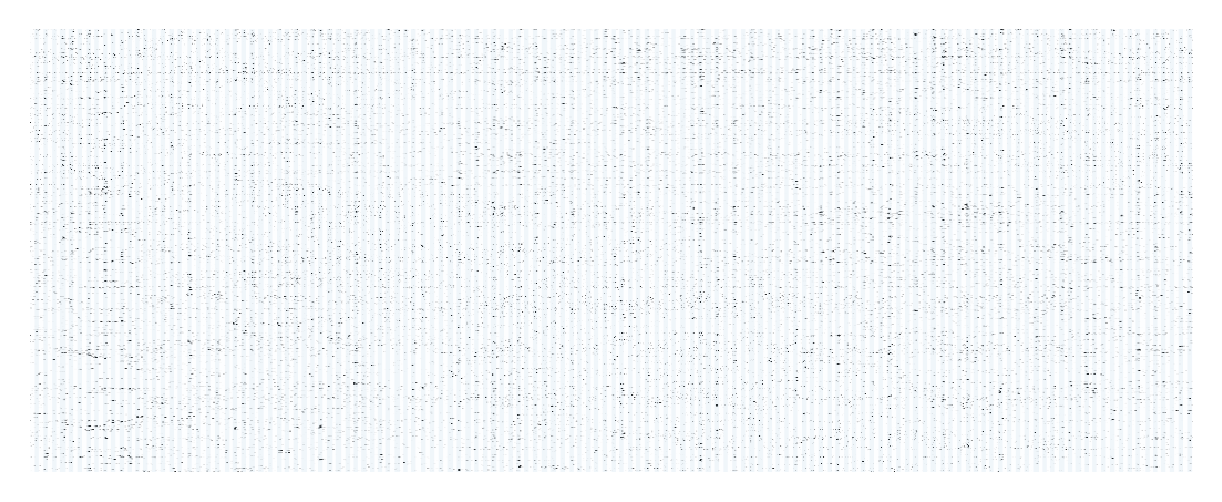

In [192]:
first_trial = 100
onset = (stimulus.Trial & scan_key & f'trial_idx = {first_trial}').fetch1('flip_times')[0][0]
duration = 1050 # in frames
sampling_freq = 1 / np.median(np.diff(field1_times_stim))
resample_freq = sampling_freq

# no filter needed if resample_freq = sampling freq
# h = np.hamming(2 * int(sampling_freq / resample_freq) + 1)
# filtered_traces = [np.convolve(t, h/sum(h), mode='same') for t in traces]
# f2as = [interp1d(field1_times_stim+d/1000,t,kind='linear') for d,t in zip(delays,filtered_traces)]
f2as = [interp1d(field1_times_stim+d/1000,t,kind='linear') for d,t in zip(delays,traces)]

#but still need to resample to line up times for all traces due to per mask delay

resample_times = np.linspace(onset,onset+duration/resample_freq,1050)
display_traces = [f2a(resample_times) for f2a in f2as]

display_traces -= np.min(display_traces,axis=1,keepdims=True)
display_traces /= np.max(display_traces,axis=1,keepdims=True)

# estimate trials that may be included
max_trial = first_trial + np.round(duration/resample_freq / (0.5+0.3)).astype(int)
max_timepoint = onset + duration/resample_freq

# fetch trial flips
trial_rest = f'trial_idx >= {first_trial} and trial_idx < {max_trial}'
trial_flips = (stimulus.Trial & scan_key & trial_rest).fetch('flip_times')

# create trial onset/offset overlay (will break for trial types other than frame)
alternating_columns = np.zeros_like(resample_times)
for trial_onset,trial_offset in np.vstack(trial_flips)[:,1:]:
    if trial_onset < max_timepoint:
        alternating_columns[np.logical_and(resample_times>=trial_onset,resample_times<=trial_offset)]=1
alternating_grid = (np.ones(displayed_units)[:,None] * (alternating_columns[None,:])) * 0.3

fig,ax = plt.subplots(figsize=(5,2),dpi=300)
ax.imshow(display_traces,vmin=0,vmax=1,cmap='binary',interpolation='none')
ax.imshow(alternating_grid,cmap='Blues',alpha=0.2,vmax=1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.show()
plt.close()

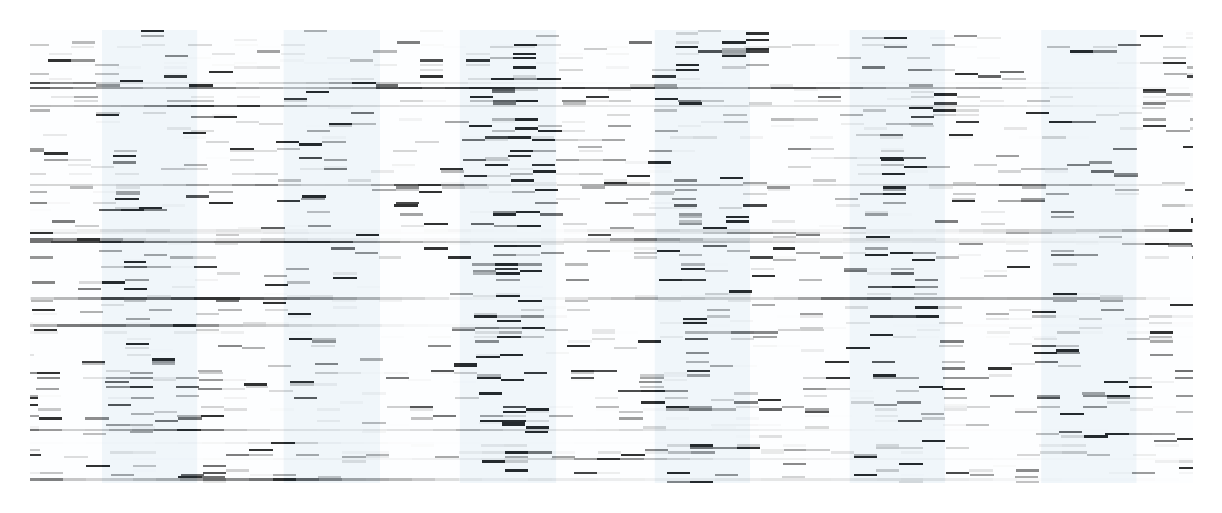

In [27]:
first_trial = 2560
onset = (stimulus.Trial & scan_key & f'trial_idx = {first_trial}').fetch1('flip_times')[0][0]
duration = 50 # in frames
sampling_freq = 1 / np.median(np.diff(field1_times_stim))
resample_freq = sampling_freq

# no filter needed if resample_freq = sampling freq
# h = np.hamming(2 * int(sampling_freq / resample_freq) + 1)
# filtered_traces = [np.convolve(t, h/sum(h), mode='same') for t in traces]
# f2as = [interp1d(field1_times_stim+d/1000,t,kind='linear') for d,t in zip(delays,filtered_traces)]

# f2as = [interp1d(field1_times_stim+d/1000,t,kind='linear') for d,t in zip(delays,traces)]
f2as = [interp1d(field1_times_stim+d/1000,t,kind='nearest') for d,t in zip(delays,traces)]


#but still need to resample to line up times for all traces due to per mask delay

resample_times = np.linspace(onset,onset+duration/resample_freq,1050)
display_traces = [f2a(resample_times) for f2a in f2as]

display_traces -= np.min(display_traces,axis=1,keepdims=True)
display_traces /= np.max(display_traces,axis=1,keepdims=True)

# estimate trials that may be included
max_trial = first_trial + np.round(duration/resample_freq / (0.5+0.3)).astype(int)
max_timepoint = onset + duration/resample_freq

# fetch trial flips
trial_rest = f'trial_idx >= {first_trial} and trial_idx < {max_trial}'
trial_flips = (stimulus.Trial & scan_key & trial_rest).fetch('flip_times')

# create trial onset/offset overlay (will break for trial types other than frame)
alternating_columns = np.zeros_like(resample_times)
for trial_onset,trial_offset in np.vstack(trial_flips)[:,1:]:
    if trial_onset < max_timepoint:
        alternating_columns[np.logical_and(resample_times>=trial_onset,resample_times<=trial_offset)]=1
alternating_grid = (np.ones(displayed_units)[:,None] * (alternating_columns[None,:])) * 0.3

fig,ax = plt.subplots(figsize=(5,2),dpi=300)
ax.imshow(display_traces,vmin=0,vmax=1,cmap='binary',interpolation='none')
ax.imshow(alternating_grid,cmap='Blues',alpha=0.2,vmax=1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('auto')

plt.show()
plt.close()

In [31]:
np.vstack(trial_flips)[:,1] < max_timepoint

array([ True,  True,  True,  True,  True,  True, False, False])

In [ ]:
stimulus.StaticImage.Image

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,trial_idx trial index within sessions,condition_hash 120-bit hash (The first 20 chars of MD5 in base64),flip_times (s) row array of flip times,last_flip the last flip number in this trial,trial_ts automatic
23964,4,22,2560,yg9vkB3mvIe2mOVf6Cgt,=BLOB=,33330,2020-06-29 14:19:04
23964,4,22,2561,8fMK/S0ZEr3FPyziyVBG,=BLOB=,33333,2020-06-29 14:19:05
23964,4,22,2562,YXPb6LLAuLF5PBCojVc2,=BLOB=,33336,2020-06-29 14:19:06
23964,4,22,2563,aehEjEq5VUzyV4ePf/9F,=BLOB=,33339,2020-06-29 14:19:07
23964,4,22,2564,CsAkTuVej7Td9tgxzYjp,=BLOB=,33342,2020-06-29 14:19:08
23964,4,22,2565,NWlbTeV1umlTmSA3+xo8,=BLOB=,33345,2020-06-29 14:19:09


In [41]:
ims = (stimulus.StaticImage.Image * (stimulus.Frame & ((stimulus.Trial & scan_key & trial_rest & 'trial_idx <= 2565')))).fetch('image')

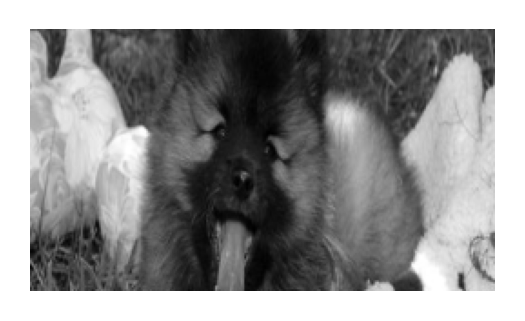

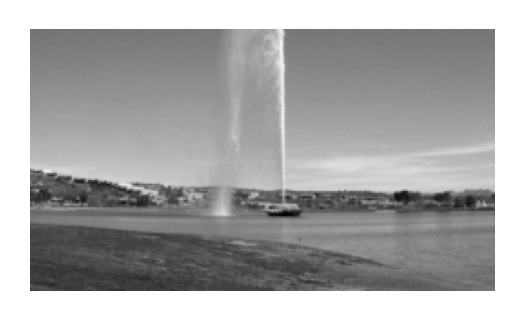

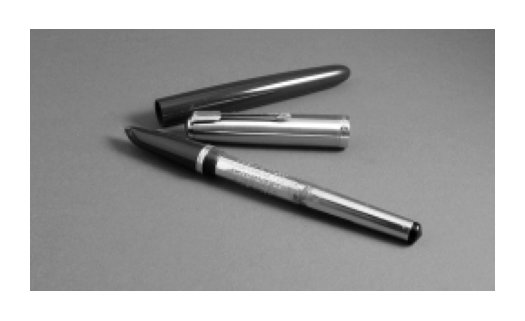

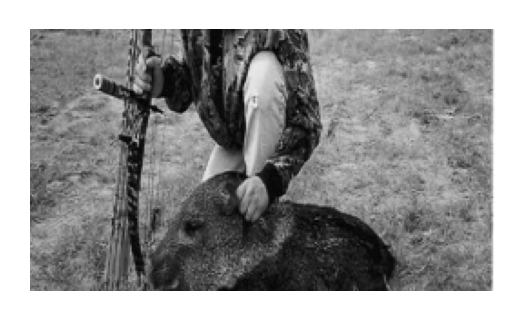

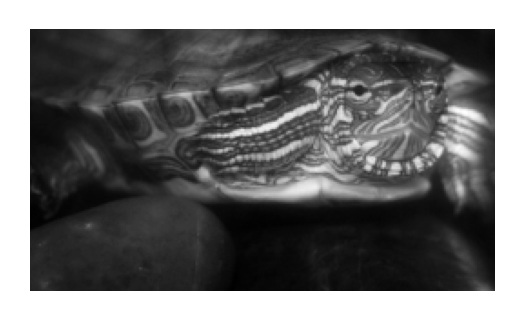

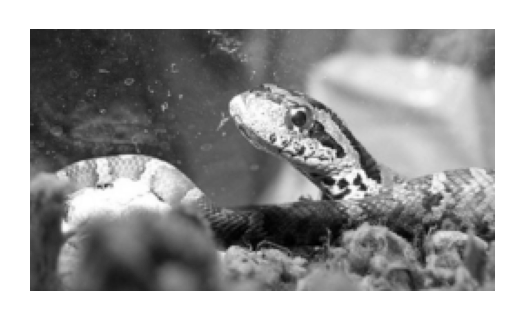

In [46]:

for im in ims:
    fig,ax = plt.subplots(figsize=(2,2),dpi=300)
    ax.imshow(im,cmap='binary_r')
    ax.set_axis_off()
    plt.show()
    plt.close()

## Frequency analysis

In [ ]:
from scipy import fft
from stimline._utils import SplineCurve

duration = 10000
offset = 100
sampling_freq = 1 / np.median(np.diff(field1_times_stim))
n_traces = 1000
    
cutoff_freqs = [0.25,0.5,1,2,4,8]
fft_mags=[]
for cutoff_freq in cutoff_freqs:
    h = np.hamming(2 * int(sampling_freq / cutoff_freq) + 1)
    filtered_traces = [np.convolve(t, h/sum(h), mode='same') for t in traces[:n_traces]]
    splines = SplineCurve(field1_times_stim[None,:] + delays[:n_traces,None]/1000, filtered_traces, k=1, ext='zeros')
    interp_traces = splines(np.linspace(np.min(field1_times_stim)+offset,
                                        np.min(field1_times_stim)+offset+duration,
                                        np.round(duration*cutoff_freq).astype(int)))
    fft_mag = np.array([np.abs(fft(t)) for t in interp_traces]).T
    fft_mags.append(fft_mag)
    
    

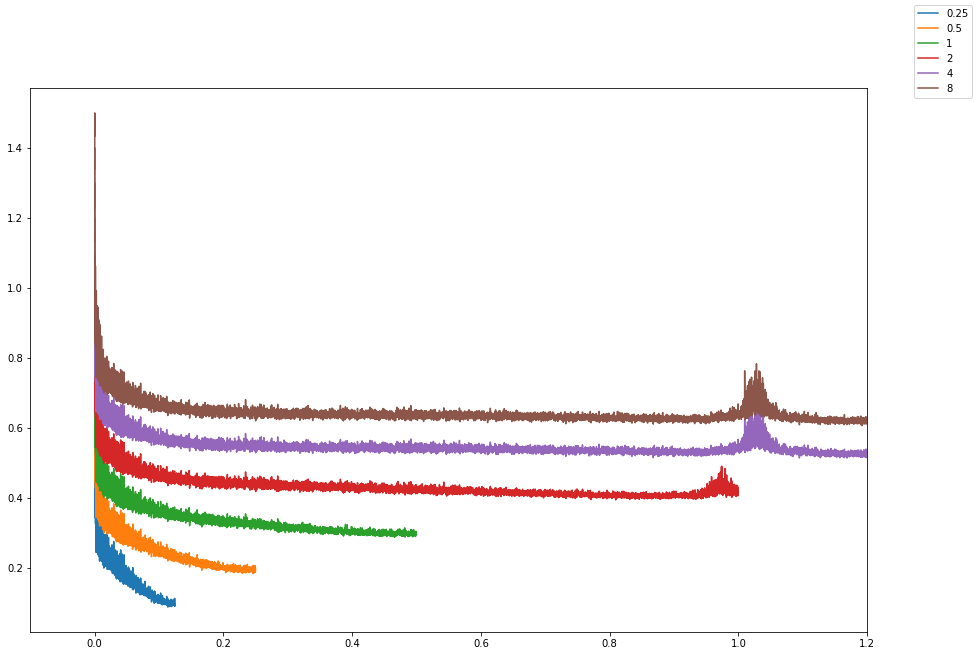

In [247]:
fig,ax = plt.subplots(figsize=(15,10))
for i,(cutoff_freq,fft_mag) in enumerate(zip(cutoff_freqs,fft_mags)):
    freq = np.fft.fftfreq(int(duration*cutoff_freq), d=1/cutoff_freq)
    mean_fft = np.mean(fft_mag,axis=1)[2:int((duration * cutoff_freq)/2)]
#     mean_fft -= np.min(mean_fft)
    mean_fft /= np.max(mean_fft)
    ax.plot(freq[2:int((duration * cutoff_freq)/2)],
             mean_fft+i/10,
             label = str(cutoff_freq))
ax.set_xlim(-0.1,1.2)
fig.legend()
    

## Radial Coordinates Colormap

(-0.5, 999.5, 999.5, -0.5)

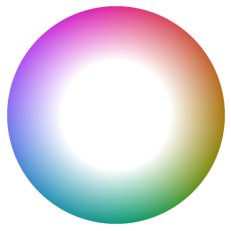

In [141]:
grad=True
grad_max=1
fig,ax = plt.subplots(facecolor='none')

xv, yv = np.meshgrid(np.linspace(-1, 1, 1000), np.linspace(-1, 1, 1000))
theta = np.arctan2(yv, xv)
r = np.sqrt(yv ** 2 + xv ** 2)

cm = cmocean.cm.phase(np.linspace(0, 1, 1000))

# ori = np.mod(theta, np.pi)
ori=theta%(2*np.pi)
vs = np.stack([np.interp(ori, np.linspace(0, 2*np.pi, 1000), cm[:, i]) for i in range(4)], axis=-1)

# outer radius of pin wheel. 1 is maximum
outer_radius = 1
inner_radius = 0.5

# define areas that fall outside of the pinwheel
outside = (r > outer_radius) | (r < inner_radius)

# controls the fading - defaults to fading linearly as one goes
# from outer_radius to inner_radius
# simply comment out this line to stop the fading
if grad:
    vs[..., -1] *= np.clip((r - inner_radius) / (outer_radius - inner_radius), 0, 1) * grad_max

vs[outside, -1] = 0

# set up background color
bg_color = 1  # set this to 0 for fade to black
bg = np.ones((1000, 1000, 4)) * bg_color
bg[..., -1] = 1
bg[outside, -1] = 0

ax.imshow(bg)
ax.imshow(np.flip(vs, axis=0))
ax.axis('off')